In [1]:
!pip install datasets

In [38]:
!pip install --upgrade pyarrow

In [11]:
from datasets import load_dataset

# Load a dataset by name
dataset =load_dataset("tkamle/sanskrit_multiline_dataset")
dataset

Generating train split:   0%|          | 0/327 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 327
    })
})

In [28]:
from datasets import DatasetDict
train_val_split = dataset['train'].train_test_split(test_size=0.3)
dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test']
})
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 145
    })
    validation: Dataset({
        features: ['text', 'image'],
        num_rows: 63
    })
})

In [19]:
def list_to_string(input_list):
    return ' '.join(input_list)

In [20]:
list_to_string(dataset['train']['text'][0])

'कुतस्त्वा कश्मलमिदं विषमे समुपस्थितम् । अनार्यजुष्टमस्वर्ग्यमकीर्तिकरमर्जुन ॥ २-२ ॥ क्लैब्यं मा स्म गमः पार्थ नैतत्त्वय्युपपद्यते । क्षुद्रं हृदयदौर्बल्यं त्यक्त्वोत्तिष्ठ परन्तप ॥ २-३ ॥'

In [4]:
from PIL import Image
import io
import ast

In [5]:
!pip install -q datasets flash_attn timm einops

In [6]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

torch.cuda.empty_cache()

Generated Description: {'Give text of the image': 'संग्रीनिनानी वारतालि पाजला: II 2-2-3-11'}
Original Description: अशोच्यानन्वशोचस्त्वं प्रज्ञावादांश्च भाषसे । गतासूनगतासुंश्च नानुशोचन्ति पण्डिताः ॥ २ - ११ ॥ न त्वेवाहं जातु नासं न त्वं नेमे जनाधिपाः । न चैव न भविष्यामः सर्वे वयमतः परम् ॥ २-१२॥
**************************************************



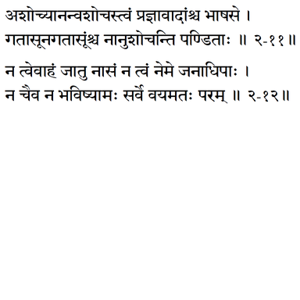

*************************************************************************************

Generated Description: {'Give text of the image': 'मासती विल्वरे सामता नाभावीति में संगराने । वारत महालायां २ कोदे।मी।। ० १ ३ ७ ४ ५ ६ ॥ ॐ ८ ्।'}
Original Description: नासतो विद्यते भावो नाभावो विद्यते सतः । उभयोरपि दृष्टोऽन्तस्त्वनयोस्तत्त्वदर्शिभिः ॥ २-१६॥ अविनाशि तु तद्विद्धि येन सर्वमिदं ततम् । विनाशमव्ययस्यास्य न कश्चित्कर्तुमर्हति ॥ २-१७॥
**************************************************



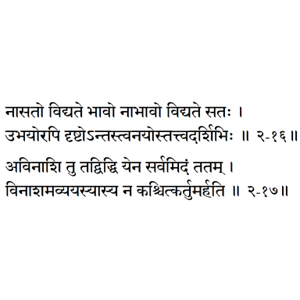

*************************************************************************************



In [22]:
def run_example(task_prompt, text_input, image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

# Test the function with a few examples from your dataset
for idx in range(8,10):
  # print("**************************************************\n")
  image =dataset['train'][idx]['image']
  description = run_example("Give text of the image", '', image)
  print(f"Generated Description: {description}")
  print(f"Original Description: {list_to_string(dataset['train'][idx]['text'])}")
  print("**************************************************\n")
  display(image.resize([300, 300]))
  print("*************************************************************************************\n")

In [19]:
#Finetuning Begins from Here

In [44]:
from torch.utils.data import Dataset

class Sanskrit(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = ' '.join(self.data[idx]['text'])
        prompt = "Give the content of the image."
        # description = list_to_string(dataset['train']['text'])
        image = dataset['train'][idx]['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return prompt, example, image

# Create datasets
train_dataset = Sanskrit(dataset['train'])
val_dataset = Sanskrit(dataset['validation'])

In [52]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm


def collate_fn(batch):
    prompts, descriptions, images = zip(*batch)
    inputs = processor(text=list(prompts), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, descriptions

# Create DataLoader
batch_size = 2  # 6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [53]:
from transformers import (AdamW, AutoProcessor, get_scheduler)


def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs, descriptions = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, descriptions = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [54]:
for param in model.vision_tower.parameters():
  param.is_trainable = False
# True for Unfrozen image encoders

In [55]:
train_model(train_loader, val_loader, model, processor, epochs=10)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/10: 100%|██████████| 73/73 [01:32<00:00,  1.27s/it]


Average Training Loss: 2.523746083860528


Validation Epoch 1/10: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


Average Validation Loss: 2.3832492008805275


Training Epoch 2/10: 100%|██████████| 73/73 [01:35<00:00,  1.31s/it]


Average Training Loss: 1.9303762455509133


Validation Epoch 2/10: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Average Validation Loss: 2.3040778562426567


Training Epoch 3/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.6866404144731286


Validation Epoch 3/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Average Validation Loss: 2.2778612710535526


Training Epoch 4/10: 100%|██████████| 73/73 [01:36<00:00,  1.33s/it]


Average Training Loss: 1.6249582800146651


Validation Epoch 4/10: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Average Validation Loss: 2.214505758136511


Training Epoch 5/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.4906114829729682


Validation Epoch 5/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Average Validation Loss: 2.1959910169243813


Training Epoch 6/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.4202053840846232


Validation Epoch 6/10: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Average Validation Loss: 2.1758385412395


Training Epoch 7/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.3526088350439724


Validation Epoch 7/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Average Validation Loss: 2.1850410625338554


Training Epoch 8/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.3078583201316938


Validation Epoch 8/10: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Average Validation Loss: 2.1782406717538834


Training Epoch 9/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.2705593239771176


Validation Epoch 9/10: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Average Validation Loss: 2.179390177130699


Training Epoch 10/10: 100%|██████████| 73/73 [01:36<00:00,  1.32s/it]


Average Training Loss: 1.25982978082683


Validation Epoch 10/10: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Average Validation Loss: 2.1763797849416733


The repository for /content/model_checkpoints/epoch_9 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co//content/model_checkpoints/epoch_9.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for /content/model_checkpoints/epoch_9 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co//content/model_checkpoints/epoch_9.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for /content/model_checkpoints/epoch_9 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co//content/model_checkpoints/epoch_9.
You can avoid this prompt in future by passing the argument `trust_remote_code=Tr

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


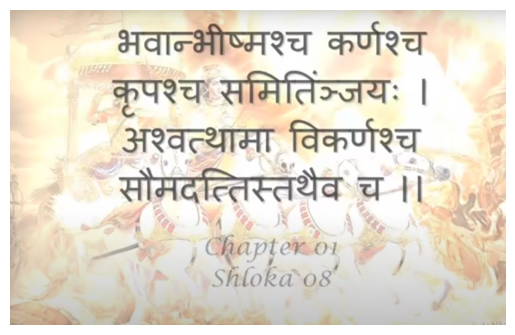

Generated Description:
{'Give text of the image.': 'भवानभीणम्य कपियचकुधये समातोति-जय: ।अशवदयागना तेकधाश् यमस्।। ने।-सभावी नि। ॥॥न्-च् २Chapter
01Shloka 08'}


In [64]:
# Testing the Model
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import textwrap

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load fine-tuned model and processor
model = AutoModelForCausalLM.from_pretrained("/content/model_checkpoints/epoch_9").to(device)
processor = AutoProcessor.from_pretrained("/content/model_checkpoints/epoch_9")

# Function to run the model on an example
def run_example(task_prompt, text_input, image_path):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Load and preprocess the image
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Tokenize inputs
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    # Generate output
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    # Ensure parsed_answer is a string
    if isinstance(parsed_answer, dict):
        parsed_answer = str(parsed_answer)

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print the description with wrapping
    wrapped_description = textwrap.fill(parsed_answer, width=120)
    print(f"Generated Description:\n{wrapped_description}")
    return parsed_answer

# Test the function with an image from your test set
image_path = "/content/sanskrit.png"
description = run_example("Give text of the image.", '', image_path)

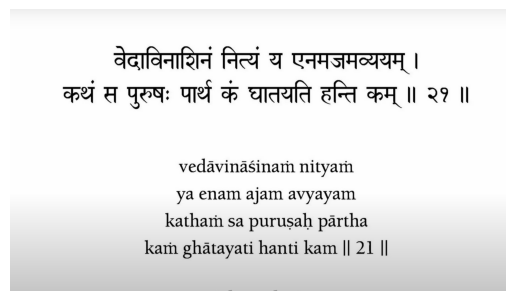

Generated Description:
{'Give text of the image.': 'तेद्तनीनानियन विрय य चन-मुधमवयु ।करे स पधृष: पाशु क चासयावी हैलि कमा ॥ ३ २ ० ४ १ ७ ५ ६ ै ॵ
ॐ ॡ ॠ ॣ ८ ॢ ्। vedavinasinasinam nityamya enam aajam avvyayamkatham sa purrusah pärthakaim ghatayati hanti kam ौ ९ ॰ ी ृ
ॸ'}


In [65]:
image_path = "/content/second.png"
description = run_example("Give text of the image.", '', image_path)

In [66]:
#Here find inside config.json and make it as:
"model_type": "davit"